# WGAN-GP

元論文 : Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

### 論文のサマリ 

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを[-c, c]にクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（=GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

### アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

#### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

#### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

#### Generator

ResNetの活性化関数はReLU

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

#### Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='../assets/WGAN-gp_ResBlock.png' width=300>

## Import and Config

In [15]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None # pyplot cmap

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CRITIC_N = 5
cfg.TRAIN.WGAN_GP_LAMBDA = 10

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [7]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x
    
    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=128, activation_fn=torch.nn.ReLU(), batch_norm=False, name=''):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        else:
            if batch_norm:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_bn' : torch.nn.BatchNorm2d(dim_first),
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
            else:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
        
        if batch_norm:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_bn' : torch.nn.BatchNorm2d(dim),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        x = torch.add(res_x, x)
        x = F.relu(x)
        return x
        
    
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.Linear(cfg.INPUT_Z_DIM, cfg.G_DIM * (cfg.OUTPUT_HEIGHT // 8) * (cfg.OUTPUT_WIDTH // 8)),
            'G_layer_1_reshape' : Reshape(cfg.G_DIM, cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_HEIGHT // 8),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_1_activation' : torch.nn.ReLU(),     
            
            'G_layer_2_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_1'),
            'G_layer_2_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_3_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_2'),
            'G_layer_3_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_4_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_3'),
            'G_layer_4_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
        
            'G_layer_out' : torch.nn.Conv2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=3, stride=1, padding=1),
            'G_layer_out_activation' : torch.nn.Tanh(),
        }))
        
    def forward(self, x):
        x = self.module(x)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()    
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_resBlock' : ResBlock(dim_first=cfg.OUTPUT_CHANNEL, dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_1'),
            'D_layer_1_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_2_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_2'),
            'D_layer_2_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_3_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_3'),

            'D_layer_4_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_4'),
            'D_layer_4_activation' : torch.nn.ReLU(),

            'D_layer_5_pool' : torch.nn.AdaptiveAvgPool2d((1, 1)),
            'D_layer_5_flatten' : Flatten(),
            'D_layer_out' : torch.nn.Linear(cfg.D_DIM, 1),
        }))

    def forward(self, x):
        x = self.module(x)
        return x
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [12]:
def result_show(G, z, path=None, save=False, show=False,  figsize=(12, 4), cmap=None):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    plt.figure(figsize=figsize)
    
    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G, cmap=cmap)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

## Train

100%|██████████| 16/16 [00:00<00:00, 1721.89it/s]

Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> True
 - Vertical >> True
 - Rotation >> 1
all data num >> 5808
dataset was completely loaded
--
training start


Iter:50, LossG (fake:448.6492), LossD:-27.8924 (real:525.8092, fake:489.2108), WDistance:36.5984, GP:8.7060
Iter:100, LossG (fake:2334.3767), LossD:269.2689 (real:1588.2050, fake:1849.3279), WDistance:-261.1229, GP:8.1460
Iter:150, LossG (fake:56338.6016), LossD:25968.1680 (real:30724.7852, fake:52908.2891), WDistance:-22183.5039, GP:3784.6646
Iter:200, LossG (fake:-64267.2695), LossD:51531.2617 (real:-101710.0000, fake:-62196.4141), WDistance:-39513.5859, GP:12017.6758
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:112566.8281), LossD:33890.6172 (real:83549.6250, fake:111930.1953), WDistance:-28380.5703, GP:5510.0459
Iter:300, LossG (fake:-90437.3594), LossD:99070.4844 (real:-133963.9062, fake:-62179.8125), WDistance:-71784.0938, GP:27286.3945
Iter:350, LossG (fake:-479407.6562), LossD:128064.6016 (real:-467502.5000, fake:-386051.9375), WDistance:-81450.5625, GP:46614.0391
Iter:400, LossG (fake:-296001.2500), LossD:131384.5469 (real:-4343

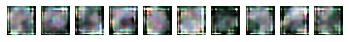

Iter:550, LossG (fake:291826.5625), LossD:79859.7656 (real:202586.5312, fake:256110.2969), WDistance:-53523.7656, GP:26335.9980
Iter:600, LossG (fake:52696.7578), LossD:77810.7656 (real:-7093.2607, fake:50153.2773), WDistance:-57246.5391, GP:20564.2305
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:-24213.0664), LossD:73151.1719 (real:-107810.2188, fake:-60782.9492), WDistance:-47027.2695, GP:26123.8984
Iter:700, LossG (fake:51839.0000), LossD:69867.5391 (real:408.3297, fake:46835.9961), WDistance:-46427.6680, GP:23439.8711
Iter:750, LossG (fake:107449.3047), LossD:73571.9531 (real:62378.7188, fake:110343.7734), WDistance:-47965.0547, GP:25606.8984
Iter:800, LossG (fake:-88311.9688), LossD:75286.3125 (real:-128584.1875, fake:-80466.5625), WDistance:-48117.6250, GP:27168.6914
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:-13608.7305), LossD:67659.9297 (real:-48358.3281, fake:-1064.3475), WDist

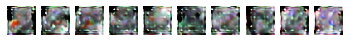

Iter:1050, LossG (fake:-99957.1250), LossD:45591.4258 (real:-124568.7266, fake:-93920.1719), WDistance:-30648.5547, GP:14942.8711
Iter:1100, LossG (fake:-326253.5625), LossD:47878.7422 (real:-374041.5625, fake:-344044.1875), WDistance:-29997.3750, GP:17881.3652
Iter:1150, LossG (fake:-323830.7188), LossD:101181.7422 (real:-414004.0625, fake:-351980.1875), WDistance:-62023.8750, GP:39157.8672
Iter:1200, LossG (fake:-45124.1562), LossD:44184.7344 (real:-60669.0898, fake:-31450.3594), WDistance:-29218.7305, GP:14966.0020
save G >> models/WGAN-GP_G_iter1200.pt, D >> models/WGAN-GP_D_iter1200.pt
Iter:1250, LossG (fake:-63226.9062), LossD:37249.8281 (real:-80110.1250, fake:-53497.0234), WDistance:-26613.1016, GP:10636.7275
Iter:1300, LossG (fake:1534.2562), LossD:41739.3867 (real:-21599.2969, fake:7208.0610), WDistance:-28807.3574, GP:12932.0303
Iter:1350, LossG (fake:21934.4473), LossD:28077.9688 (real:18766.4746, fake:38439.3125), WDistance:-19672.8379, GP:8405.1299
Iter:1400, LossG (fake:

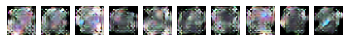

Iter:1550, LossG (fake:145195.2656), LossD:41954.8242 (real:98528.3594, fake:127795.1484), WDistance:-29266.7891, GP:12688.0361
Iter:1600, LossG (fake:158135.8594), LossD:31496.0723 (real:120477.4922, fake:143739.5312), WDistance:-23262.0391, GP:8234.0332
save G >> models/WGAN-GP_G_iter1600.pt, D >> models/WGAN-GP_D_iter1600.pt
Iter:1650, LossG (fake:109820.5469), LossD:42344.3047 (real:58639.9062, fake:88650.3906), WDistance:-30010.4844, GP:12333.8193
Iter:1700, LossG (fake:-19506.4512), LossD:38259.0156 (real:-68857.5000, fake:-43275.7891), WDistance:-25581.7109, GP:12677.3057
Iter:1750, LossG (fake:-19194.3340), LossD:33234.5859 (real:-24560.8438, fake:-1121.4180), WDistance:-23439.4258, GP:9795.1602
Iter:1800, LossG (fake:98741.9219), LossD:29939.6270 (real:102624.4922, fake:124200.0156), WDistance:-21575.5234, GP:8364.1035
save G >> models/WGAN-GP_G_iter1800.pt, D >> models/WGAN-GP_D_iter1800.pt
Iter:1850, LossG (fake:-57979.6250), LossD:71245.2344 (real:-202710.6250, fake:-165055

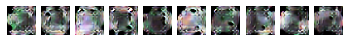

Iter:2050, LossG (fake:-1901.7181), LossD:26892.6914 (real:-23736.1133, fake:-4499.1348), WDistance:-19236.9785, GP:7655.7124
Iter:2100, LossG (fake:75939.4531), LossD:23917.6680 (real:43190.1406, fake:60901.9648), WDistance:-17711.8242, GP:6205.8428
Iter:2150, LossG (fake:-20446.5332), LossD:26811.3320 (real:-32632.8008, fake:-13178.0254), WDistance:-19454.7754, GP:7356.5571
Iter:2200, LossG (fake:-15183.9219), LossD:26448.8770 (real:-30643.4023, fake:-11963.4336), WDistance:-18679.9688, GP:7768.9087
save G >> models/WGAN-GP_G_iter2200.pt, D >> models/WGAN-GP_D_iter2200.pt
Iter:2250, LossG (fake:18524.7852), LossD:21972.0938 (real:26208.9453, fake:43927.3633), WDistance:-17718.4180, GP:4253.6758
Iter:2300, LossG (fake:-120340.3906), LossD:35095.0898 (real:-115784.9766, fake:-90324.8203), WDistance:-25460.1562, GP:9634.9336
Iter:2350, LossG (fake:156211.4375), LossD:22590.3711 (real:115970.5938, fake:129730.2031), WDistance:-13759.6094, GP:8830.7627
Iter:2400, LossG (fake:155518.6406),

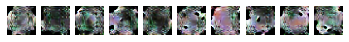

Iter:2550, LossG (fake:180512.7656), LossD:26832.3301 (real:124795.9062, fake:144256.1875), WDistance:-19460.2812, GP:7372.0483
Iter:2600, LossG (fake:152153.9844), LossD:25753.7441 (real:118507.8359, fake:135987.9062), WDistance:-17480.0703, GP:8273.6738
save G >> models/WGAN-GP_G_iter2600.pt, D >> models/WGAN-GP_D_iter2600.pt
Iter:2650, LossG (fake:-64034.4219), LossD:20455.0215 (real:-59712.1328, fake:-43927.5859), WDistance:-15784.5469, GP:4670.4746
Iter:2700, LossG (fake:90288.4609), LossD:21050.0000 (real:85104.1797, fake:99364.4688), WDistance:-14260.2891, GP:6789.7114
Iter:2750, LossG (fake:68163.0625), LossD:14556.1650 (real:62043.9805, fake:72723.7344), WDistance:-10679.7539, GP:3876.4114
Iter:2800, LossG (fake:77558.6641), LossD:29739.2949 (real:22781.1406, fake:40923.6250), WDistance:-18142.4844, GP:11596.8105
save G >> models/WGAN-GP_G_iter2800.pt, D >> models/WGAN-GP_D_iter2800.pt
Iter:2850, LossG (fake:-12172.8594), LossD:33709.9414 (real:-27534.5820, fake:-7113.6133), W

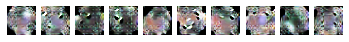

Iter:3050, LossG (fake:22825.7520), LossD:13701.0762 (real:10243.3770, fake:19828.9688), WDistance:-9585.5918, GP:4115.4844
Iter:3100, LossG (fake:6865.9038), LossD:25180.5039 (real:4187.0576, fake:22941.1602), WDistance:-18754.1016, GP:6426.4014
Iter:3150, LossG (fake:112782.2422), LossD:21698.7344 (real:76601.0312, fake:91674.8125), WDistance:-15073.7812, GP:6624.9541
Iter:3200, LossG (fake:31736.9395), LossD:21334.4727 (real:8826.6514, fake:24379.3594), WDistance:-15552.7080, GP:5781.7656
save G >> models/WGAN-GP_G_iter3200.pt, D >> models/WGAN-GP_D_iter3200.pt
Iter:3250, LossG (fake:-41103.7734), LossD:18142.1758 (real:-59658.8906, fake:-46290.3047), WDistance:-13368.5859, GP:4773.5898
Iter:3300, LossG (fake:-48139.3828), LossD:44583.5469 (real:-54936.3906, fake:-21917.7500), WDistance:-33018.6406, GP:11564.9082
Iter:3350, LossG (fake:108072.7500), LossD:16563.7852 (real:87017.3750, fake:98673.3672), WDistance:-11655.9922, GP:4907.7939
Iter:3400, LossG (fake:-65254.2266), LossD:261

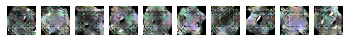

Iter:3550, LossG (fake:-13453.7344), LossD:22055.7695 (real:-17904.8242, fake:-1040.1743), WDistance:-16864.6504, GP:5191.1201
Iter:3600, LossG (fake:-31623.7930), LossD:21243.3398 (real:-42226.6367, fake:-26322.8203), WDistance:-15903.8164, GP:5339.5239
save G >> models/WGAN-GP_G_iter3600.pt, D >> models/WGAN-GP_D_iter3600.pt
Iter:3650, LossG (fake:-38585.9453), LossD:20056.9961 (real:-61356.8828, fake:-47375.7188), WDistance:-13981.1641, GP:6075.8320
Iter:3700, LossG (fake:-34097.5234), LossD:16182.7148 (real:-45052.0195, fake:-34134.8711), WDistance:-10917.1484, GP:5265.5664
Iter:3750, LossG (fake:-26552.2637), LossD:22237.9434 (real:-43393.6797, fake:-28172.0723), WDistance:-15221.6074, GP:7016.3359
Iter:3800, LossG (fake:-49563.3711), LossD:36923.5781 (real:-73643.3047, fake:-49876.2070), WDistance:-23767.0977, GP:13156.4785
save G >> models/WGAN-GP_G_iter3800.pt, D >> models/WGAN-GP_D_iter3800.pt
Iter:3850, LossG (fake:-110290.2188), LossD:24901.3477 (real:-143581.6406, fake:-127

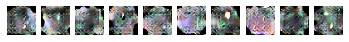

Iter:4050, LossG (fake:-69177.7266), LossD:16189.4863 (real:-76860.3281, fake:-65130.9375), WDistance:-11729.3906, GP:4460.0957
Iter:4100, LossG (fake:-89627.8125), LossD:22796.3789 (real:-140067.6875, fake:-126261.5703), WDistance:-13806.1172, GP:8990.2617
Iter:4150, LossG (fake:-39663.4297), LossD:13830.0859 (real:-43791.5156, fake:-33771.3633), WDistance:-10020.1523, GP:3809.9341
Iter:4200, LossG (fake:31349.8203), LossD:16438.8359 (real:22947.4395, fake:33300.6250), WDistance:-10353.1855, GP:6085.6514
save G >> models/WGAN-GP_G_iter4200.pt, D >> models/WGAN-GP_D_iter4200.pt
Iter:4250, LossG (fake:9983.7773), LossD:16827.2480 (real:-17087.4336, fake:-5949.0688), WDistance:-11138.3652, GP:5688.8828
Iter:4300, LossG (fake:-12006.5293), LossD:9262.7217 (real:-14202.7793, fake:-7744.9326), WDistance:-6457.8467, GP:2804.8752
Iter:4350, LossG (fake:-2338.0396), LossD:11893.7305 (real:-18218.2422, fake:-9985.3193), WDistance:-8232.9229, GP:3660.8071
Iter:4400, LossG (fake:-24848.7891), Los

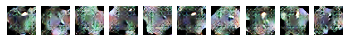

Iter:4550, LossG (fake:-25427.4902), LossD:11155.5127 (real:-27332.9492, fake:-19428.6133), WDistance:-7904.3359, GP:3251.1768
Iter:4600, LossG (fake:-43530.6016), LossD:19176.1914 (real:-42665.5195, fake:-27737.9883), WDistance:-14927.5312, GP:4248.6611
save G >> models/WGAN-GP_G_iter4600.pt, D >> models/WGAN-GP_D_iter4600.pt
Iter:4650, LossG (fake:-50206.0117), LossD:11030.7383 (real:-39169.7031, fake:-30579.2930), WDistance:-8590.4102, GP:2440.3276
Iter:4700, LossG (fake:43448.0273), LossD:16466.6406 (real:4328.2871, fake:15437.2910), WDistance:-11109.0039, GP:5357.6372
Iter:4750, LossG (fake:-61743.5664), LossD:15361.0137 (real:-48753.8438, fake:-36815.1562), WDistance:-11938.6875, GP:3422.3267
Iter:4800, LossG (fake:-40126.1094), LossD:28792.1836 (real:-64646.6953, fake:-43735.9375), WDistance:-20910.7578, GP:7881.4263
save G >> models/WGAN-GP_G_iter4800.pt, D >> models/WGAN-GP_D_iter4800.pt
Iter:4850, LossG (fake:2997.8979), LossD:14008.7354 (real:-14299.8281, fake:-4350.1797), W

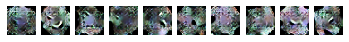

Iter:5050, LossG (fake:-55954.8047), LossD:11218.1689 (real:-31303.7598, fake:-22615.1289), WDistance:-8688.6309, GP:2529.5378
Iter:5100, LossG (fake:-59978.9102), LossD:15881.4766 (real:-60384.6602, fake:-47820.1211), WDistance:-12564.5391, GP:3316.9375
Iter:5150, LossG (fake:-22227.6777), LossD:10119.1289 (real:-20621.4062, fake:-13314.9727), WDistance:-7306.4336, GP:2812.6948
Iter:5200, LossG (fake:-52211.0898), LossD:13133.3574 (real:-51814.2383, fake:-42284.4141), WDistance:-9529.8242, GP:3603.5337
save G >> models/WGAN-GP_G_iter5200.pt, D >> models/WGAN-GP_D_iter5200.pt
Iter:5250, LossG (fake:-4178.4790), LossD:10233.2656 (real:-10765.1113, fake:-3276.0156), WDistance:-7489.0957, GP:2744.1699
Iter:5300, LossG (fake:-45333.0000), LossD:9285.6338 (real:-26886.8477, fake:-19685.0195), WDistance:-7201.8281, GP:2083.8057
Iter:5350, LossG (fake:-14161.1914), LossD:10577.5215 (real:-29957.3320, fake:-23689.0488), WDistance:-6268.2832, GP:4309.2383
Iter:5400, LossG (fake:-21092.9980), Lo

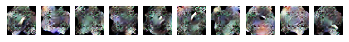

Iter:5550, LossG (fake:40867.6523), LossD:11195.3740 (real:35443.5977, fake:44077.8789), WDistance:-8634.2812, GP:2561.0928
Iter:5600, LossG (fake:-14179.7012), LossD:16316.3945 (real:-29727.6445, fake:-18602.9102), WDistance:-11124.7344, GP:5191.6602
save G >> models/WGAN-GP_G_iter5600.pt, D >> models/WGAN-GP_D_iter5600.pt
Iter:5650, LossG (fake:3155.2810), LossD:9408.1377 (real:119.7495, fake:6506.9956), WDistance:-6387.2461, GP:3020.8914
Iter:5700, LossG (fake:-21656.9023), LossD:8526.7715 (real:-25940.8730, fake:-19567.2012), WDistance:-6373.6719, GP:2153.0999
Iter:5750, LossG (fake:11940.9590), LossD:13134.0996 (real:4065.5603, fake:13142.6738), WDistance:-9077.1133, GP:4056.9858
Iter:5800, LossG (fake:-49339.0469), LossD:17128.4180 (real:-54258.6836, fake:-41774.7383), WDistance:-12483.9453, GP:4644.4717
save G >> models/WGAN-GP_G_iter5800.pt, D >> models/WGAN-GP_D_iter5800.pt
Iter:5850, LossG (fake:9797.1602), LossD:19285.4375 (real:1088.0144, fake:13790.1514), WDistance:-12702.

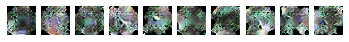

Iter:6050, LossG (fake:-26095.2695), LossD:9842.8086 (real:-21787.7344, fake:-14294.6035), WDistance:-7493.1309, GP:2349.6782
Iter:6100, LossG (fake:20763.9805), LossD:14785.4014 (real:11826.6582, fake:22552.9297), WDistance:-10726.2715, GP:4059.1296
Iter:6150, LossG (fake:47275.8047), LossD:31017.4102 (real:27193.3867, fake:48219.2578), WDistance:-21025.8711, GP:9991.5400
Iter:6200, LossG (fake:28972.4883), LossD:12436.6455 (real:12390.7949, fake:20394.4941), WDistance:-8003.6992, GP:4432.9463
save G >> models/WGAN-GP_G_iter6200.pt, D >> models/WGAN-GP_D_iter6200.pt
Iter:6250, LossG (fake:-13857.2061), LossD:12964.2520 (real:-17788.7598, fake:-8154.8086), WDistance:-9633.9512, GP:3330.3013
Iter:6300, LossG (fake:-46977.1406), LossD:21646.1328 (real:-69092.9141, fake:-54900.6406), WDistance:-14192.2734, GP:7453.8604
Iter:6350, LossG (fake:-2246.8818), LossD:16811.4219 (real:10501.8984, fake:22710.3828), WDistance:-12208.4844, GP:4602.9375
Iter:6400, LossG (fake:-49157.6992), LossD:1796

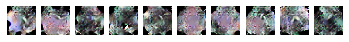

Iter:6550, LossG (fake:43354.9922), LossD:12353.5127 (real:37615.1797, fake:46345.1953), WDistance:-8730.0156, GP:3623.4973
Iter:6600, LossG (fake:-18313.5508), LossD:13085.0273 (real:-16561.3379, fake:-6992.7695), WDistance:-9568.5684, GP:3516.4590
save G >> models/WGAN-GP_G_iter6600.pt, D >> models/WGAN-GP_D_iter6600.pt
Iter:6650, LossG (fake:-44592.3359), LossD:8467.1113 (real:-54928.9336, fake:-49651.1797), WDistance:-5277.7539, GP:3189.3569
Iter:6700, LossG (fake:-38200.6758), LossD:18751.9766 (real:-60300.6406, fake:-47599.7930), WDistance:-12700.8477, GP:6051.1279
Iter:6750, LossG (fake:-45509.2500), LossD:15723.1543 (real:-58141.7891, fake:-47380.2773), WDistance:-10761.5117, GP:4961.6431
Iter:6800, LossG (fake:31910.4375), LossD:16343.5801 (real:13946.8359, fake:24622.1133), WDistance:-10675.2773, GP:5668.3032
save G >> models/WGAN-GP_G_iter6800.pt, D >> models/WGAN-GP_D_iter6800.pt
Iter:6850, LossG (fake:-53695.5547), LossD:8911.4844 (real:-36431.2305, fake:-29633.2109), WDis

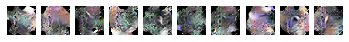

Iter:7050, LossG (fake:18432.4102), LossD:11430.6484 (real:18972.4258, fake:26920.2559), WDistance:-7947.8301, GP:3482.8184
Iter:7100, LossG (fake:-32718.4316), LossD:11371.1816 (real:-35118.2344, fake:-27410.1758), WDistance:-7708.0586, GP:3663.1226
Iter:7150, LossG (fake:9244.7832), LossD:10723.2598 (real:27680.8516, fake:35454.8984), WDistance:-7774.0469, GP:2949.2124
Iter:7200, LossG (fake:17476.0625), LossD:10018.4629 (real:4991.7061, fake:11161.8672), WDistance:-6170.1611, GP:3848.3020
save G >> models/WGAN-GP_G_iter7200.pt, D >> models/WGAN-GP_D_iter7200.pt
Iter:7250, LossG (fake:-27905.2988), LossD:32103.8594 (real:-48553.5039, fake:-23866.4746), WDistance:-24687.0293, GP:7416.8291
Iter:7300, LossG (fake:43781.8672), LossD:15608.2627 (real:18851.5684, fake:29277.5586), WDistance:-10425.9902, GP:5182.2725
Iter:7350, LossG (fake:40931.5117), LossD:11128.5918 (real:34093.4375, fake:41681.6719), WDistance:-7588.2344, GP:3540.3574
Iter:7400, LossG (fake:-41595.2891), LossD:13388.567

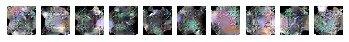

Iter:7550, LossG (fake:61190.9531), LossD:16846.2930 (real:42368.1172, fake:53413.9414), WDistance:-11045.8242, GP:5800.4678
Iter:7600, LossG (fake:84945.0781), LossD:15607.8818 (real:82247.2500, fake:94241.7188), WDistance:-11994.4688, GP:3613.4131
save G >> models/WGAN-GP_G_iter7600.pt, D >> models/WGAN-GP_D_iter7600.pt
Iter:7650, LossG (fake:-16364.1240), LossD:8738.1309 (real:-7169.2920, fake:-755.2740), WDistance:-6414.0181, GP:2324.1133
Iter:7700, LossG (fake:-19221.4570), LossD:15268.9531 (real:-38201.4023, fake:-27055.5195), WDistance:-11145.8828, GP:4123.0703
Iter:7750, LossG (fake:-58803.1914), LossD:10555.3809 (real:-58131.7734, fake:-50158.8320), WDistance:-7972.9414, GP:2582.4395
Iter:7800, LossG (fake:796.4514), LossD:11701.6797 (real:-12287.2930, fake:-4976.3970), WDistance:-7310.8960, GP:4390.7842
save G >> models/WGAN-GP_G_iter7800.pt, D >> models/WGAN-GP_D_iter7800.pt
Iter:7850, LossG (fake:-127552.7734), LossD:24772.8438 (real:-121668.7188, fake:-102891.6406), WDista

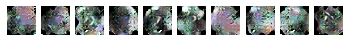

Iter:8050, LossG (fake:-24773.9219), LossD:12124.0547 (real:-40478.5391, fake:-32132.3516), WDistance:-8346.1875, GP:3777.8672
Iter:8100, LossG (fake:-25761.1406), LossD:13455.0156 (real:-25475.7148, fake:-15649.9072), WDistance:-9825.8076, GP:3629.2075
Iter:8150, LossG (fake:-13534.3486), LossD:12430.6133 (real:-15548.2812, fake:-6450.2773), WDistance:-9098.0039, GP:3332.6096
Iter:8200, LossG (fake:20789.4355), LossD:11993.3047 (real:20108.9023, fake:29290.3633), WDistance:-9181.4609, GP:2811.8442
save G >> models/WGAN-GP_G_iter8200.pt, D >> models/WGAN-GP_D_iter8200.pt
Iter:8250, LossG (fake:-23367.6914), LossD:11578.5439 (real:-29869.4707, fake:-22575.2246), WDistance:-7294.2461, GP:4284.2979
Iter:8300, LossG (fake:-125424.7344), LossD:27492.8477 (real:-159231.9688, fake:-141903.7656), WDistance:-17328.2031, GP:10164.6445
Iter:8350, LossG (fake:73406.8438), LossD:9192.3926 (real:55107.6602, fake:62051.6836), WDistance:-6944.0234, GP:2248.3687
Iter:8400, LossG (fake:-39504.9453), Los

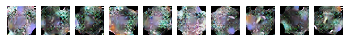

Iter:8550, LossG (fake:1273.1139), LossD:13976.0391 (real:-13600.9414, fake:-4559.2812), WDistance:-9041.6602, GP:4934.3789
Iter:8600, LossG (fake:82934.9688), LossD:13861.4424 (real:64772.2305, fake:74157.5703), WDistance:-9385.3398, GP:4476.1025
save G >> models/WGAN-GP_G_iter8600.pt, D >> models/WGAN-GP_D_iter8600.pt
Iter:8650, LossG (fake:73143.9375), LossD:14424.8555 (real:64254.5469, fake:73957.8672), WDistance:-9703.3203, GP:4721.5352
Iter:8700, LossG (fake:118552.8594), LossD:21303.9980 (real:97202.7344, fake:112183.0625), WDistance:-14980.3281, GP:6323.6694
Iter:8750, LossG (fake:160181.5625), LossD:24393.3965 (real:135801.5625, fake:154709.6250), WDistance:-18908.0625, GP:5485.3340
Iter:8800, LossG (fake:56059.4922), LossD:9905.4385 (real:42405.5781, fake:49038.4336), WDistance:-6632.8555, GP:3272.5830
save G >> models/WGAN-GP_G_iter8800.pt, D >> models/WGAN-GP_D_iter8800.pt
Iter:8850, LossG (fake:65647.5938), LossD:12611.7842 (real:55928.4648, fake:64289.5547), WDistance:-83

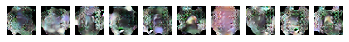

Iter:9050, LossG (fake:-38984.2344), LossD:9130.1631 (real:-47329.8125, fake:-40578.2656), WDistance:-6751.5469, GP:2378.6162
Iter:9100, LossG (fake:50187.5859), LossD:11639.7773 (real:38752.6328, fake:46958.6523), WDistance:-8206.0195, GP:3433.7573
Iter:9150, LossG (fake:45381.5117), LossD:10117.5322 (real:28919.5703, fake:36084.4805), WDistance:-7164.9102, GP:2952.6218
Iter:9200, LossG (fake:102480.0547), LossD:11322.5215 (real:82693.9375, fake:91048.4375), WDistance:-8354.5000, GP:2968.0210
save G >> models/WGAN-GP_G_iter9200.pt, D >> models/WGAN-GP_D_iter9200.pt
Iter:9250, LossG (fake:62715.3398), LossD:12498.2148 (real:53982.7305, fake:63439.8555), WDistance:-9457.1250, GP:3041.0903
Iter:9300, LossG (fake:177599.5625), LossD:13031.5332 (real:148211.9375, fake:157365.9844), WDistance:-9154.0469, GP:3877.4866
Iter:9350, LossG (fake:160476.4375), LossD:12532.7646 (real:129822.8438, fake:139295.9844), WDistance:-9473.1406, GP:3059.6243
Iter:9400, LossG (fake:-23740.8008), LossD:9406.4

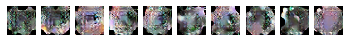

Iter:9550, LossG (fake:42182.8164), LossD:13362.2080 (real:22692.3926, fake:33047.0430), WDistance:-10354.6504, GP:3007.5576
Iter:9600, LossG (fake:28451.7969), LossD:10569.6494 (real:26024.8516, fake:33084.5977), WDistance:-7059.7461, GP:3509.9033
save G >> models/WGAN-GP_G_iter9600.pt, D >> models/WGAN-GP_D_iter9600.pt
Iter:9650, LossG (fake:15385.2305), LossD:9695.5322 (real:7699.2500, fake:14789.7676), WDistance:-7090.5176, GP:2605.0146
Iter:9700, LossG (fake:34842.4180), LossD:12088.0410 (real:15898.1934, fake:23396.2539), WDistance:-7498.0605, GP:4589.9810
Iter:9750, LossG (fake:52237.6641), LossD:13589.8438 (real:36837.1641, fake:45659.2344), WDistance:-8822.0703, GP:4767.7734
Iter:9800, LossG (fake:-3383.6418), LossD:11011.0381 (real:8458.3359, fake:16965.5332), WDistance:-8507.1973, GP:2503.8411
save G >> models/WGAN-GP_G_iter9800.pt, D >> models/WGAN-GP_D_iter9800.pt
Iter:9850, LossG (fake:-84927.5156), LossD:28944.1992 (real:-102897.5000, fake:-81185.4141), WDistance:-21712.

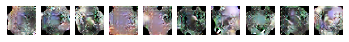

final paramters were saved to G >> models/WGAN-GP_G_final.pt, D >> models/WGAN-GP_D_final.pt
loss was saved to >> result/WGAN-GP_loss.txt


In [9]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []
    list_loss_GP = []

    one = torch.FloatTensor([1])
    minus_one = one * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # sample X
            Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            
            #---
            # Gradient Penalty
            #---
            # sample epsilon from [0, 1]
            epsilon = np.random.random()

            # sample x_hat 
            x_hat = (epsilon * Xs + (1 - epsilon) * Gz).requires_grad_(True)
            
            Dx_hat = D(x_hat)
            musk = torch.ones_like(Dx_hat)
            gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
            gradients = gradients.view(-1, 1)
            gradient_penalty = cfg.TRAIN.WGAN_GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # loss backward
            loss_D_real.backward(one, retain_graph=True)
            loss_D_fake.backward(minus_one, retain_graph=True)
            gradient_penalty.backward(retain_graph=True)

            loss_D = loss_D_fake - loss_D_real + gradient_penalty
            Wasserstein_distance = loss_D_real - loss_D_fake

            opt_D.step()
            

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(one)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()
        _gradient_penalty = gradient_penalty.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                list_loss_GP.append(_gradient_penalty)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}, GP:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance, _gradient_penalty))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance,
                          'GP' : list_loss_GP})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN-GP_result_1.jpg


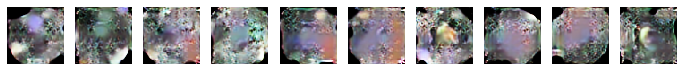

result was saved to >> result/WGAN-GP_result_2.jpg


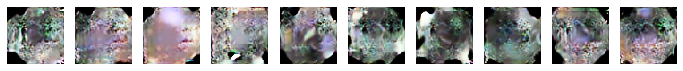

In [16]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(cfg.TEST.ITERATION):
            z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
